In [1]:
!pip install utils

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install eofs

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install netCDF4

Defaulting to user installation because normal site-packages is not writeable


In [4]:
! pip install netcdf4 xarray[io] cartopy nc-time-axis

Defaulting to user installation because normal site-packages is not writeable


In [6]:
!pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [8]:
!pip install --user xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 14.4 MB/s eta 0:00:0000:0100:01


In [9]:
!pip install utils

Defaulting to user installation because normal site-packages is not writeable


In [133]:
import os
import datetime as dt  # Python standard library datetime  module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from eofs.xarray import Eof
import utils
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [12]:
#get the test y data
test_inputs = pd.read_csv('test_data.csv').set_index('Unnamed: 0')
test_inputs

,CO2,CH4,SO2_0,SO2_1,SO2_2,SO2_3,SO2_4,BC_0,BC_1,BC_2,BC_3,BC_4
Unnamed: 0,,,,,,,,,,,,
2015,0.640030,0.622895,0.903505,2.331736,-0.104266,-1.138111,1.045259,2.706810,-1.375172,-0.819380,-0.256301,-1.716714
2016,0.655024,0.622868,0.857117,2.261433,0.078151,-1.083139,0.977491,2.648897,-1.303500,-0.707064,-0.314685,-1.616016
2017,0.670164,0.622841,0.810728,2.191129,0.260569,-1.028166,0.909724,2.590985,-1.231828,-0.594749,-0.373069,-1.515319
2018,0.685449,0.622814,0.764340,2.120826,0.442987,-0.973193,0.841956,2.533072,-1.160157,-0.482433,-0.431453,-1.414621
2019,0.700880,0.622787,0.717951,2.050522,0.625405,-0.918221,0.774188,2.475159,-1.088485,-0.370117,-0.489837,-1.313923
...,...,...,...,...,...,...,...,...,...,...,...,...
2096,1.859445,0.469562,0.178097,0.697813,1.189839,-0.064685,0.033707,0.434483,-0.189906,-0.115759,-0.230166,0.147331
2097,1.866250,0.468973,0.177501,0.687329,1.167448,-0.080802,0.006906,0.422541,-0.181722,-0.101978,-0.213992,0.169751
2098,1.872799,0.468383,0.176905,0.676844,1.145056,-0.096920,-0.019895,0.410599,-0.173539,-0.088197,-0.197818,0.192172


In [13]:
#get the test x data
test_X = xr.open_dataset('inputs_ssp245.nc').compute()
test_X

<xarray.Dataset>
Dimensions:    (time: 86, longitude: 144, latitude: 96)
Coordinates:
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * time       (time) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
Data variables:
    CO2        (time) float64 1.536e+03 1.572e+03 ... 4.51e+03 4.524e+03
    SO2        (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CH4        (time) float64 0.3737 0.3737 0.3737 ... 0.281 0.2807 0.2803
    BC         (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [14]:
test_Y = xr.open_dataset('outputs_ssp245.nc').compute()
test_Y

<xarray.Dataset>
Dimensions:                    (lat: 96, lon: 144, time: 86, member: 3)
Coordinates:
  * lat                        (lat) float64 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                        (lon) float64 0.0 2.5 5.0 ... 352.5 355.0 357.5
  * time                       (time) int64 2015 2016 2017 ... 2098 2099 2100
    quantile                   float64 0.9
  * member                     (member) int64 1 2 3
Data variables:
    diurnal_temperature_range  (member, time, lat, lon) float32 0.1953 ... -0...
    tas                        (member, time, lat, lon) float32 1.601 ... 5.677
    pr                         (member, time, lat, lon) float32 9.877e-09 ......
    pr90                       (member, time, lat, lon) float64 -1.104e-07 .....

In [15]:
#extract each actual y variables
tas_truth = test_Y["tas"].mean('member')
pr_truth = test_Y["pr"].mean('member') * 86400
pr90_truth = test_Y["pr90"].mean('member') * 86400
dtr_truth = test_Y["diurnal_temperature_range"].mean('member')

In [11]:
#get the training data for tas
Xy_train_tas = pd.read_csv('Xy_train_tas.csv').drop(columns = 'Unnamed: 0')
Xy_train_tas

,CO2,CH4,SO2_0,SO2_1,SO2_2,SO2_3,SO2_4,BC_0,BC_1,BC_2,...,"(90.0, 335.0)","(90.0, 337.5)","(90.0, 340.0)","(90.0, 342.5)","(90.0, 345.0)","(90.0, 347.5)","(90.0, 350.0)","(90.0, 352.5)","(90.0, 355.0)","(90.0, 357.5)"
0,0.000078,0.052177,-0.684515,-0.666947,-0.537510,-0.028525,-0.113818,-0.692262,-0.130168,-0.232393,...,0.913116,0.913289,0.913116,0.912933,0.912893,0.912659,0.912384,0.912181,0.911825,0.911611
1,0.000157,0.052903,-0.687033,-0.663856,-0.545009,-0.005502,-0.125350,-0.692450,-0.126097,-0.237947,...,0.042501,0.042679,0.049225,0.055695,0.055506,0.055227,0.054789,0.054230,0.053604,0.052897
2,0.000239,0.053630,-0.683973,-0.664691,-0.542393,-0.004230,-0.127326,-0.693939,-0.145096,-0.220875,...,1.167440,1.167389,1.169657,1.172119,1.172201,1.172190,1.172292,1.172424,1.172709,1.173228
3,0.000325,0.054356,-0.681914,-0.665113,-0.541201,-0.003263,-0.128716,-0.695386,-0.164126,-0.203961,...,-0.339457,-0.339589,-0.332387,-0.324961,-0.324956,-0.325038,-0.325063,-0.325033,-0.325022,-0.324880
4,0.000425,0.055082,-0.655500,-0.682270,-0.499379,-0.101005,-0.084503,-0.702971,-0.281864,-0.087136,...,0.577006,0.576996,0.585297,0.593811,0.593740,0.593719,0.593648,0.593801,0.593760,0.593943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,0.567126,0.595031,-0.842055,-0.578323,-0.771408,0.497734,-0.341834,-0.907528,0.998584,-0.727501,...,2.024526,2.024689,2.012695,2.000763,2.000722,2.000590,2.000488,2.000631,2.000468,2.000621
749,0.581259,0.600918,-0.842055,-0.578323,-0.771408,0.497734,-0.341834,-0.907528,0.998584,-0.727501,...,3.675151,3.674947,3.682241,3.689789,3.689870,3.689992,3.690033,3.690602,3.690918,3.691579
750,0.595592,0.610851,-0.842055,-0.578323,-0.771408,0.497734,-0.341834,-0.907528,0.998584,-0.727501,...,3.218984,3.219035,3.211863,3.204804,3.204742,3.204631,3.204692,3.204763,3.204844,3.205027
751,0.610341,0.616287,-0.842055,-0.578323,-0.771408,0.497734,-0.341834,-0.907528,0.998584,-0.727501,...,2.249318,2.249095,2.243428,2.237996,2.238261,2.238678,2.239177,2.239929,2.240936,2.242371


In [16]:
X_train_tas=Xy_train_tas.iloc[:,0:12]#split training data of tas for x
y_train_tas=Xy_train_tas.iloc[:,12:13836]#split training data of tas for y

In [135]:
#set up tas estimator
xgb_tas = xgb.XGBRegressor()

In [134]:
param_grid = {
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)],
    'max_depth': np.arange(3, 8),
    'min_child_weight': np.arange(1, 6),
    'subsample': np.linspace(0.8, 1.0, 5),
    'colsample_bytree': np.linspace(0.8, 1.0, 5)
}

In [136]:
random_search = RandomizedSearchCV(
    estimator=xgb_tas,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  # Use negative RMSE as scoring metric
    cv=3,  # Number of cross-validation folds
    verbose=2,  # Print progress information
    n_jobs=-1  # Use all available CPU cores
)

In [137]:
random_search.fit(X_train_tas, y_train_tas)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.8500000000000001, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=100, subsample=0.8; total time=22.8min
[CV] END colsample_bytree=0.8500000000000001, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=100, subsample=0.8; total time=27.6min
[CV] END colsample_bytree=0.8500000000000001, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=100, subsample=0.8; total time=30.9min
[CV] END colsample_bytree=0.8, learning_rate=0.03111111111111111, max_depth=7, min_child_weight=4, n_estimators=300, subsample=0.8; total time=82.5min
[CV] END colsample_bytree=0.8, learning_rate=0.03111111111111111, max_depth=7, min_child_weight=4, n_estimators=300, subsample=0.8; total time=97.3min
[CV] END colsample_bytree=0.8, learning_rate=0.03111111111111111, max_depth=7, min_child_weight=4, n_estimators=300, subsample=0.8; total time=103.5min
[CV] END colsample_bytree=0.9, lear

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': array([0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                        'learning_rate': array([0.01      , 0.03111111, 0.05222222, 0.07333333, 0.09444444,
       0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ]),
                                        'max_depth': array([3, 4, 5, 6, 7]),
                                        'min_child_weight': array([1, 2, 3, 4, 5]),
                                        'n_estimators': [100, 150, 200, 250,
                                                         300],
                                        'subsample': array([0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                   scoring='neg_mean_squared_error', verbose=2)

In [138]:
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 4, 'max_depth': 7, 'learning_rate': 0.03111111111111111, 'colsample_bytree': 1.0}


In [139]:
#get the model with best parameter
best_xgb_tas = random_search.best_estimator_

In [91]:
model_tas = xgb_tas.get_booster()

In [141]:
pred_tas = best_xgb_tas.predict(test_inputs)
pred_tas

array([[1.0674653, 1.0421916, 1.0347705, ..., 3.421879 , 3.3876297,
        3.3333206],
       [1.1494627, 1.1082925, 1.071453 , ..., 3.4340181, 3.331136 ,
        3.3058367],
       [1.1686149, 1.110045 , 1.0899385, ..., 3.460669 , 3.411153 ,
        3.369945 ],
       ...,
       [1.911181 , 1.9528594, 1.7597753, ..., 7.0270114, 7.1535707,
        7.143152 ],
       [1.911181 , 1.9528594, 1.7597753, ..., 7.0312963, 7.1752152,
        7.143152 ],
       [1.9972855, 2.0153296, 1.8672013, ..., 7.020134 , 7.1752152,
        7.133971 ]], dtype=float32)

In [142]:
pred_tas = pred_tas.reshape(86,96,144)

In [143]:
def rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data.mean()

In [144]:
#calculate the rmse between actual y and predict y
print(f"RMSE: {rmse(tas_truth[35], pred_tas[35])}")
print(f"RMSE: {rmse(tas_truth[85], pred_tas[85])}")
print(f"RMSE: {rmse(tas_truth[30:40], pred_tas[30:40])}")
print(f"RMSE: {rmse(tas_truth[75:], pred_tas[75:])}")
print(f"RMSE: {rmse(tas_truth[35:], pred_tas[35:])}")
print("\n")

RMSE: 0.4088558767721661
RMSE: 0.5362323186961263
RMSE: 0.4459694638137227
RMSE: 0.5552381975190029
RMSE: 0.5535732722215069




In [145]:
#create xr dataset for tas
xr_output_tas=xr.Dataset(coords={'time': test_X.time.values, 'lat': test_X.latitude.values, 'lon': test_X.longitude.values})
xr_output_tas["tas"]=(['time', 'lat', 'lon'],  pred_tas)

In [146]:
#create xr dataset for tas1
xr_output_tas1=xr.Dataset(coords={'time': test_X.time.values, 'lat': test_X.latitude.values, 'lon': test_X.longitude.values})
xr_output_tas1["tas"]=(['time', 'lat', 'lon'],  pred_tas1)

In [147]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import transforms

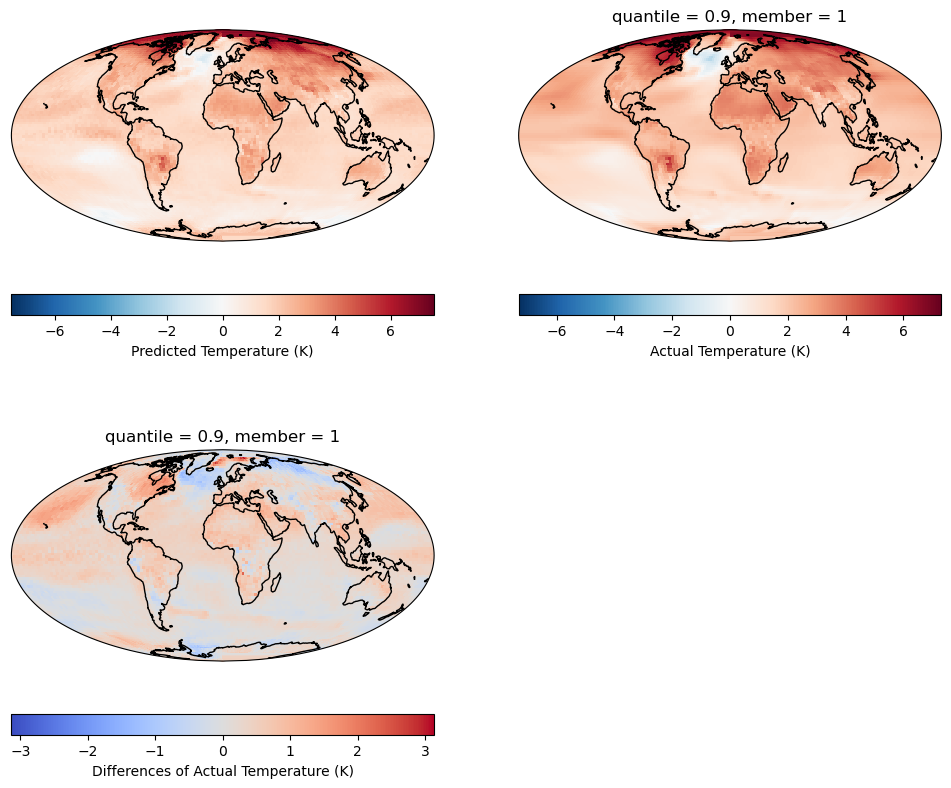

In [190]:
#getting plot for the predicted temperature
fig = plt.figure(figsize=(12, 10))
plt.subplot(221, projection=ccrs.Mollweide())
xr_output_tas['tas'].sel(time=slice(2080, 2100)).mean(['time']).plot(transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Predicted Temperature (K)", "orientation":'horizontal'})
plt.gca().coastlines()
#getting plot for the actual temperature
plt.subplot(222,projection=ccrs.Mollweide())
test_Y["tas"].sel(time=slice(2080,2100),member=1).mean(['time']).plot(transform=ccrs.PlateCarree(),
                                                                     cbar_kwargs={"label":"Actual Temperature (K)", "orientation":'horizontal'})
plt.gca().coastlines()
#getting plot for the differences
diff_tas = test_Y["tas"].sel(time=slice(2080,2100),member=1).mean(['time']) - xr_output_tas['tas'].sel(time=slice(2080, 2100)).mean(['time'])
plt.subplot(223, projection=ccrs.Mollweide())
diff_tas.plot(cmap='coolwarm', transform=ccrs.PlateCarree(),cbar_kwargs={"label":"Differences of Actual Temperature (K)", "orientation":'horizontal'})
plt.gca().coastlines()

In [149]:
#get the training data for dtr
Xy_train_dtr = pd.read_csv('Xy_train_dtr.csv').drop(columns = 'Unnamed: 0')
Xy_train_dtr

,CO2,CH4,SO2_0,SO2_1,SO2_2,SO2_3,SO2_4,BC_0,BC_1,BC_2,...,"(90.0, 335.0)","(90.0, 337.5)","(90.0, 340.0)","(90.0, 342.5)","(90.0, 345.0)","(90.0, 347.5)","(90.0, 350.0)","(90.0, 352.5)","(90.0, 355.0)","(90.0, 357.5)"
0,0.000078,0.052177,-0.684515,-0.666947,-0.537510,-0.028525,-0.113818,-0.692262,-0.130168,-0.232393,...,0.166478,0.166435,0.164865,0.164217,0.164243,0.164290,0.164359,0.164442,0.164574,0.164720
1,0.000157,0.052903,-0.687033,-0.663856,-0.545009,-0.005502,-0.125350,-0.692450,-0.126097,-0.237947,...,0.161903,0.161912,0.156851,0.152227,0.152262,0.152349,0.152488,0.152701,0.152973,0.153328
2,0.000239,0.053630,-0.683973,-0.664691,-0.542393,-0.004230,-0.127326,-0.693939,-0.145096,-0.220875,...,0.124674,0.124764,0.124930,0.120251,0.120217,0.120156,0.120063,0.119931,0.119754,0.119508
3,0.000325,0.054356,-0.681914,-0.665113,-0.541201,-0.003263,-0.128716,-0.695386,-0.164126,-0.203961,...,-0.191083,-0.190923,-0.198926,-0.204640,-0.204767,-0.204969,-0.205254,-0.205605,-0.206051,-0.206619
4,0.000425,0.055082,-0.655500,-0.682270,-0.499379,-0.101005,-0.084503,-0.702971,-0.281864,-0.087136,...,-0.009050,-0.009144,-0.014526,-0.022177,-0.022034,-0.021790,-0.021440,-0.020984,-0.020428,-0.019762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,0.567126,0.595031,-0.842055,-0.578323,-0.771408,0.497734,-0.341834,-0.907528,0.998584,-0.727501,...,-0.260417,-0.260480,-0.255221,-0.249748,-0.249715,-0.249664,-0.249589,-0.249476,-0.249344,-0.249194
749,0.581259,0.600918,-0.842055,-0.578323,-0.771408,0.497734,-0.341834,-0.907528,0.998584,-0.727501,...,-0.141279,-0.141290,-0.143714,-0.144913,-0.144888,-0.144843,-0.144778,-0.144689,-0.144578,-0.144476
750,0.595592,0.610851,-0.842055,-0.578323,-0.771408,0.497734,-0.341834,-0.907528,0.998584,-0.727501,...,-0.403432,-0.403304,-0.410674,-0.418573,-0.418617,-0.418687,-0.418792,-0.418944,-0.419144,-0.419415
751,0.610341,0.616287,-0.842055,-0.578323,-0.771408,0.497734,-0.341834,-0.907528,0.998584,-0.727501,...,-0.352315,-0.352122,-0.353837,-0.356475,-0.356624,-0.356878,-0.357230,-0.357691,-0.358273,-0.359005


In [150]:
X_train_dtr=Xy_train_dtr.iloc[:,0:12]#split training data of dtr for x
y_train_dtr=Xy_train_dtr.iloc[:,12:13836]#split training data of dtr for y

In [152]:
#set up dtr estimator
xgb_dtr = xgb.XGBRegressor()

In [154]:
random_search_dtr = RandomizedSearchCV(
    estimator=xgb_dtr,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  # Use negative RMSE as scoring metric
    cv=3,  # Number of cross-validation folds
    verbose=2,  # Print progress information
    n_jobs=-1  # Use all available CPU cores
)

In [ ]:
random_search.fit(X_train_dtr, y_train_dtr)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.9, learning_rate=0.1788888888888889, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.9; total time=28.0min
[CV] END colsample_bytree=0.9, learning_rate=0.1788888888888889, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.9; total time=34.0min
[CV] END colsample_bytree=0.9, learning_rate=0.1788888888888889, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.9; total time=34.9min
[CV] END colsample_bytree=1.0, learning_rate=0.07333333333333333, max_depth=3, min_child_weight=1, n_estimators=250, subsample=1.0; total time=18.6min
[CV] END colsample_bytree=1.0, learning_rate=0.07333333333333333, max_depth=3, min_child_weight=1, n_estimators=250, subsample=1.0; total time=19.5min
[CV] END colsample_bytree=1.0, learning_rate=0.07333333333333333, max_depth=3, min_child_weight=1, n_estimators=250, subsample=1.0; total time=21.9min
[CV] END colsample_bytree=1.0, learn

In [166]:
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'subsample': 0.9, 'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.052222222222222225, 'colsample_bytree': 1.0}


In [167]:
#get the model with best parameter
best_xgb_dtr = random_search.best_estimator_

In [107]:
model_dtr = xgb_dtr.get_booster()

In [169]:
pred_dtr1 = best_xgb_dtr.predict(test_inputs)

In [170]:
pred_dtr1 = pred_dtr1.reshape(86,96,144)

In [171]:
#calculate the rmse between actual y and predict y for sklearn
print(f"RMSE: {rmse(dtr_truth[35], pred_dtr1[35])}")
print(f"RMSE: {rmse(dtr_truth[85], pred_dtr1[85])}")
print(f"RMSE: {rmse(dtr_truth[30:40], pred_dtr1[30:40])}")
print(f"RMSE: {rmse(dtr_truth[75:], pred_dtr1[75:])}")
print(f"RMSE: {rmse(dtr_truth[35:], pred_dtr1[35:])}")
print("\n")

RMSE: 0.1613808757227576
RMSE: 0.16984190800743898
RMSE: 0.1641727345967188
RMSE: 0.1876704303950217
RMSE: 0.17923427714986945




In [172]:
#create xr dataset for dtr
xr_output_dtr=xr.Dataset(coords={'time': test_X.time.values, 'lat': test_X.latitude.values, 'lon': test_X.longitude.values})
xr_output_dtr["diurnal_temperature_range"]=(['time', 'lat', 'lon'],  pred_dtr1)

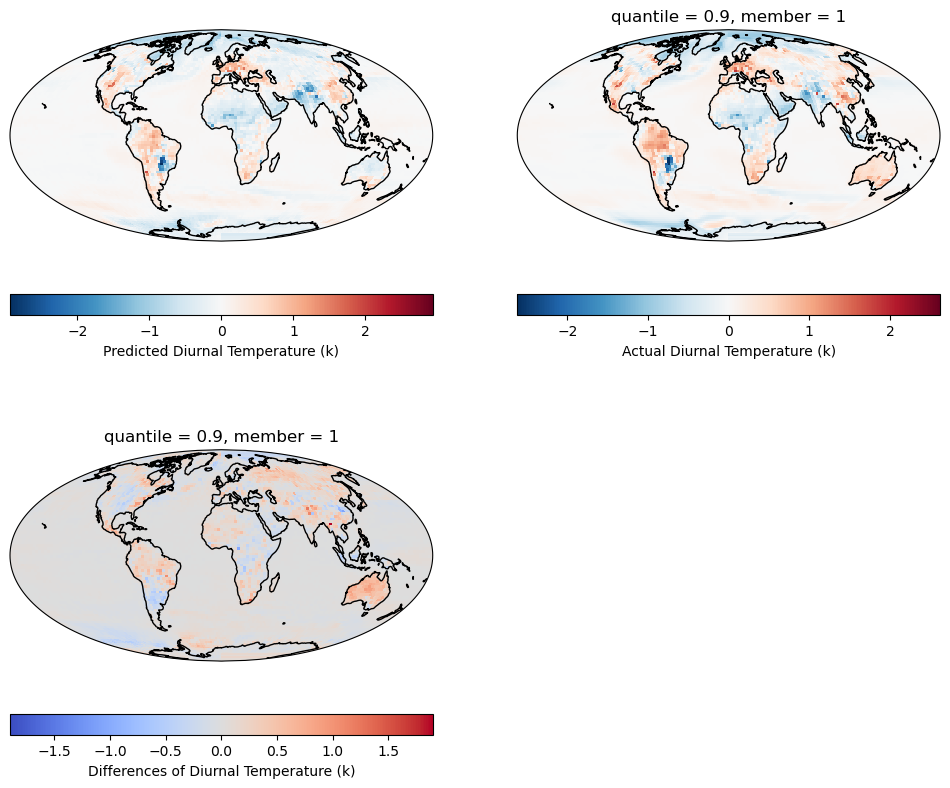

In [189]:
#getting plot for the predicted dtr
fig = plt.figure(figsize=(12, 10))
plt.subplot(221, projection=ccrs.Mollweide())
xr_output_dtr['diurnal_temperature_range'].sel(time=slice(2080, 2100)).mean(['time']).plot(transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Predicted Diurnal Temperature (k)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting plot for the actual dtr

plt.subplot(222, projection=ccrs.Mollweide())
test_Y["diurnal_temperature_range"].sel(time=slice(2080,2100),member=1).mean(['time']).plot(transform=ccrs.PlateCarree(),
                                                                     cbar_kwargs={"label":"Actual Diurnal Temperature (k)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting the abs differences between actual and predicted dtr
diff_dtr = test_Y["diurnal_temperature_range"].sel(time=slice(2080,2100),member=1).mean(['time']) - xr_output_dtr["diurnal_temperature_range"].sel(time=slice(2080, 2100)).mean(['time'])

plt.subplot(223, projection=ccrs.Mollweide())
diff_dtr.plot(cmap='coolwarm', transform=ccrs.PlateCarree(),cbar_kwargs={"label":"Differences of Diurnal Temperature (k)", "orientation":'horizontal'})
plt.gca().coastlines()

In [174]:
#get the training data for pr
Xy_train_pr = pd.read_csv('Xy_train_pr.csv').drop(columns = 'Unnamed: 0')
Xy_train_pr

,CO2,CH4,SO2_0,SO2_1,SO2_2,SO2_3,SO2_4,BC_0,BC_1,BC_2,...,"(90.0, 335.0)","(90.0, 337.5)","(90.0, 340.0)","(90.0, 342.5)","(90.0, 345.0)","(90.0, 347.5)","(90.0, 350.0)","(90.0, 352.5)","(90.0, 355.0)","(90.0, 357.5)"
0,0.000078,0.052177,-0.684515,-0.666947,-0.537510,-0.028525,-0.113818,-0.692262,-0.130168,-0.232393,...,0.036784,0.036798,0.036943,0.036726,0.036859,0.036860,0.036633,0.036620,0.036639,0.036620
1,0.000157,0.052903,-0.687033,-0.663856,-0.545009,-0.005502,-0.125350,-0.692450,-0.126097,-0.237947,...,-0.038304,-0.038316,-0.038376,-0.038366,-0.038358,-0.038336,-0.038401,-0.038374,-0.038320,-0.038341
2,0.000239,0.053630,-0.683973,-0.664691,-0.542393,-0.004230,-0.127326,-0.693939,-0.145096,-0.220875,...,0.022622,0.022642,0.022576,0.022617,0.022640,0.022666,0.022607,0.022623,0.022586,0.022602
3,0.000325,0.054356,-0.681914,-0.665113,-0.541201,-0.003263,-0.128716,-0.695386,-0.164126,-0.203961,...,-0.029990,-0.030011,-0.029848,-0.029757,-0.029828,-0.029833,-0.029830,-0.029871,-0.029840,-0.029847
4,0.000425,0.055082,-0.655500,-0.682270,-0.499379,-0.101005,-0.084503,-0.702971,-0.281864,-0.087136,...,-0.041499,-0.041483,-0.041527,-0.041484,-0.041498,-0.041454,-0.041495,-0.041464,-0.041452,-0.041467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,0.567126,0.595031,-0.842055,-0.578323,-0.771408,0.497734,-0.341834,-0.907528,0.998584,-0.727501,...,0.038115,0.038083,0.038103,0.038124,0.038126,0.038106,0.038135,0.038137,0.038142,0.038175
749,0.581259,0.600918,-0.842055,-0.578323,-0.771408,0.497734,-0.341834,-0.907528,0.998584,-0.727501,...,0.119079,0.119059,0.119195,0.119061,0.119084,0.119035,0.119021,0.119075,0.119090,0.119059
750,0.595592,0.610851,-0.842055,-0.578323,-0.771408,0.497734,-0.341834,-0.907528,0.998584,-0.727501,...,0.030459,0.030365,0.030604,0.030441,0.030482,0.030455,0.030467,0.030450,0.030473,0.030461
751,0.610341,0.616287,-0.842055,-0.578323,-0.771408,0.497734,-0.341834,-0.907528,0.998584,-0.727501,...,0.042405,0.042418,0.042523,0.042467,0.042461,0.042455,0.042474,0.042439,0.042446,0.042583


In [177]:
X_train_pr=Xy_train_pr.iloc[:,0:12]#split training data of pr for x
y_train_pr=Xy_train_pr.iloc[:,12:13836]#split training data of pr for y

In [10]:
#convert pr into regression matrix
train_pr = xgb.DMatrix(X_train_pr, y_train_pr)

In [176]:
#set up pr estimator
xgb_pr = xgb.XGBRegressor()

In [178]:
random_search_pr = RandomizedSearchCV(
    estimator=xgb_dtr,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  # Use negative RMSE as scoring metric
    cv=3,  # Number of cross-validation folds
    verbose=2,  # Print progress information
    n_jobs=-1  # Use all available CPU cores
)

In [179]:
random_search_pr.fit(X_train_pr, y_train_pr)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.95, learning_rate=0.03111111111111111, max_depth=7, min_child_weight=4, n_estimators=300, subsample=1.0; total time=84.8min
[CV] END colsample_bytree=0.95, learning_rate=0.03111111111111111, max_depth=7, min_child_weight=4, n_estimators=300, subsample=1.0; total time=98.3min
[CV] END colsample_bytree=0.95, learning_rate=0.03111111111111111, max_depth=7, min_child_weight=4, n_estimators=300, subsample=1.0; total time=106.0min
[CV] END colsample_bytree=0.8, learning_rate=0.1788888888888889, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.95; total time=34.2min
[CV] END colsample_bytree=0.8, learning_rate=0.1788888888888889, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.95; total time=33.5min
[CV] END colsample_bytree=0.8, learning_rate=0.1788888888888889, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.95; total time=42.5min
[CV] END colsample_bytree=0.8

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': array([0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                        'learning_rate': array([0.01      , 0.03111111, 0.05222222, 0.07333333, 0.09444444,
       0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ]),
                                        'max_depth': array([3, 4, 5, 6, 7]),
                                        'min_child_weight': array([1, 2, 3, 4, 5]),
                                        'n_estimators': [100, 150, 200, 250,
                                                         300],
                                        'subsample': array([0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                   scoring='neg_mean_squared_error', verbose=2)

In [181]:
print("Best Hyperparameters:", random_search_pr.best_params_)

Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 4, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [182]:
best_xgb_pr = random_search_pr.best_estimator_

In [116]:
#get the model with best parameter
model_pr = xgb_pr.get_booster()

In [183]:
pred_pr1 = best_xgb_pr.predict(test_inputs)

In [184]:
pred_pr1 = pred_pr1.reshape(86, 96, 144)

In [185]:
#getting rmse for pr
print(f"RMSE: {rmse(pr_truth[35], pred_pr1[35])}")
print(f"RMSE: {rmse(pr_truth[85], pred_pr1[85])}")
print(f"RMSE: {rmse(pr_truth[30:40], pred_pr1[30:40])}")
print(f"RMSE: {rmse(pr_truth[75:], pred_pr1[75:])}")
print(f"RMSE: {rmse(pr_truth[35:], pred_pr1[35:])}")
print("\n")

RMSE: 0.45157161733717815
RMSE: 0.681892774343103
RMSE: 0.5418228934023746
RMSE: 0.5933584599284152
RMSE: 0.5790836215938765




In [186]:
#create xr dataset for pr
xr_output_pr=xr.Dataset(coords={'time': test_X.time.values, 'lat': test_X.latitude.values, 'lon': test_X.longitude.values})
xr_output_pr["pr"]=(['time', 'lat', 'lon'],  pred_pr1)

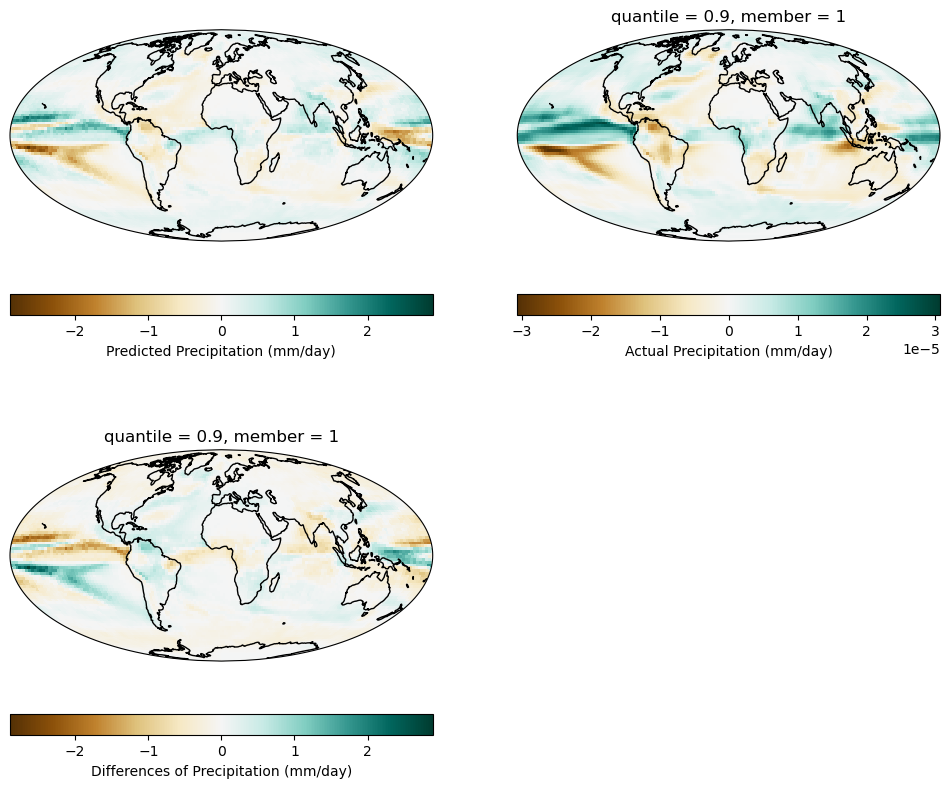

In [188]:
#getting plot for the predicted pr
fig = plt.figure(figsize=(12, 10))
plt.subplot(221, projection=ccrs.Mollweide())
xr_output_pr['pr'].sel(time=slice(2080, 2100)).mean(['time']).plot(cmap="BrBG", transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Predicted Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting plot for the actual pr

plt.subplot(222, projection=ccrs.Mollweide())
test_Y['pr'].sel(time=slice(2080, 2100),member=1).mean(['time']).plot(cmap="BrBG", transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Actual Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting the abs difference between actual and predicted pr
diff_pr = test_Y["pr"].sel(time=slice(2080,2100),member=1).mean(['time']) - xr_output_pr["pr"].sel(time=slice(2080, 2100)).mean(['time'])

plt.subplot(223, projection=ccrs.Mollweide())
diff_pr.plot(cmap='BrBG', transform=ccrs.PlateCarree(),cbar_kwargs={"label":"Differences of Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

In [191]:
#get the training data for pr90
Xy_train_pr90 = pd.read_csv('Xy_train_pr90.csv').drop(columns = 'Unnamed: 0')
Xy_train_pr90

,CO2,CH4,SO2_0,SO2_1,SO2_2,SO2_3,SO2_4,BC_0,BC_1,BC_2,...,"(90.0, 335.0)","(90.0, 337.5)","(90.0, 340.0)","(90.0, 342.5)","(90.0, 345.0)","(90.0, 347.5)","(90.0, 350.0)","(90.0, 352.5)","(90.0, 355.0)","(90.0, 357.5)"
0,0.000078,0.052177,-0.684515,-0.666947,-0.537510,-0.028525,-0.113818,-0.692262,-0.130168,-0.232393,...,0.170421,0.170512,0.170785,0.170177,0.169988,0.170086,0.170023,0.169999,0.169756,0.169877
1,0.000157,0.052903,-0.687033,-0.663856,-0.545009,-0.005502,-0.125350,-0.692450,-0.126097,-0.237947,...,-0.027692,-0.027635,-0.029214,-0.024403,-0.024572,-0.024434,-0.024638,-0.024431,-0.025050,-0.024925
2,0.000239,0.053630,-0.683973,-0.664691,-0.542393,-0.004230,-0.127326,-0.693939,-0.145096,-0.220875,...,0.045116,0.045207,0.045060,0.045476,0.046138,0.045293,0.045342,0.045325,0.045064,0.045162
3,0.000325,0.054356,-0.681914,-0.665113,-0.541201,-0.003263,-0.128716,-0.695386,-0.164126,-0.203961,...,-0.052382,-0.052331,-0.053359,-0.051923,-0.052069,-0.052000,-0.052047,-0.052104,-0.052335,-0.052264
4,0.000425,0.055082,-0.655500,-0.682270,-0.499379,-0.101005,-0.084503,-0.702971,-0.281864,-0.087136,...,-0.103203,-0.103131,-0.102134,-0.102256,-0.102426,-0.102361,-0.102412,-0.102478,-0.102715,-0.102658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,0.567126,0.595031,-0.842055,-0.578323,-0.771408,0.497734,-0.341834,-0.907528,0.998584,-0.727501,...,-0.068055,-0.068058,-0.068707,-0.069410,-0.069569,-0.069477,-0.069491,-0.069510,-0.069687,-0.069555
749,0.581259,0.600918,-0.842055,-0.578323,-0.771408,0.497734,-0.341834,-0.907528,0.998584,-0.727501,...,0.342780,0.342240,0.342946,0.341484,0.340782,0.341122,0.341513,0.341565,0.342268,0.341350
750,0.595592,0.610851,-0.842055,-0.578323,-0.771408,0.497734,-0.341834,-0.907528,0.998584,-0.727501,...,0.093556,0.093591,0.093457,0.092428,0.092272,0.092376,0.092380,0.092391,0.092238,0.092412
751,0.610341,0.616287,-0.842055,-0.578323,-0.771408,0.497734,-0.341834,-0.907528,0.998584,-0.727501,...,0.102049,0.102020,0.101435,0.102603,0.102448,0.102556,0.102537,0.102563,0.102391,0.100377


In [192]:
X_train_pr90=Xy_train_pr90.iloc[:,0:12]#split training data of tas for x
y_train_pr90=Xy_train_pr90.iloc[:,12:13836]#split training data of tas for y

In [195]:
#set up pr90 estimator
xgb_pr90 = xgb.XGBRegressor()

In [196]:
random_search_pr90 = RandomizedSearchCV(
    estimator=xgb_pr90,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  # Use negative RMSE as scoring metric
    cv=3,  # Number of cross-validation folds
    verbose=2,  # Print progress information
    n_jobs=-1  # Use all available CPU cores
)

In [197]:
random_search_pr90.fit(X_train_pr90, y_train_pr90)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=1.0, learning_rate=0.052222222222222225, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.95; total time=12.4min
[CV] END colsample_bytree=1.0, learning_rate=0.052222222222222225, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.95; total time=17.2min
[CV] END colsample_bytree=1.0, learning_rate=0.052222222222222225, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.95; total time=13.5min
[CV] END colsample_bytree=0.95, learning_rate=0.1577777777777778, max_depth=6, min_child_weight=3, n_estimators=250, subsample=0.95; total time=50.4min
[CV] END colsample_bytree=0.95, learning_rate=0.1577777777777778, max_depth=6, min_child_weight=3, n_estimators=250, subsample=0.95; total time=66.3min
[CV] END colsample_bytree=0.95, learning_rate=0.1577777777777778, max_depth=6, min_child_weight=3, n_estimators=250, subsample=0.95; total time=69.9min
[CV] END colsample_bytre

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': array([0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                        'learning_rate': array([0.01      , 0.03111111, 0.05222222, 0.07333333, 0.09444444,
       0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ]),
                                        'max_depth': array([3, 4, 5, 6, 7]),
                                        'min_child_weight': array([1, 2, 3, 4, 5]),
                                        'n_estimators': [100, 150, 200, 250,
                                                         300],
                                        'subsample': array([0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                   scoring='neg_mean_squared_error', verbose=2)

In [198]:
print("Best Hyperparameters:", random_search_pr90.best_params_)

Best Hyperparameters: {'subsample': 0.95, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.07333333333333333, 'colsample_bytree': 0.95}


In [199]:
#get the model with best parameter
best_xgb_pr90 = random_search_pr90.best_estimator_

In [200]:
pred_pr901 = best_xgb_pr90.predict(test_inputs)

In [201]:
pred_pr901 = pred_pr901.reshape(86, 96, 144)

In [202]:
#getting rmse for predicted y and actual y
print(f"RMSE: {rmse(pr90_truth[35], pred_pr901[35])}")
print(f"RMSE: {rmse(pr90_truth[85], pred_pr901[85])}")
print(f"RMSE: {rmse(pr90_truth[30:40], pred_pr901[30:40])}")
print(f"RMSE: {rmse(pr90_truth[75:], pred_pr901[75:])}")
print(f"RMSE: {rmse(pr90_truth[35:], pred_pr901[35:])}")
print("\n")

RMSE: 1.5344656294210353
RMSE: 1.9951812755864209
RMSE: 1.7330777769013852
RMSE: 1.7800617887476387
RMSE: 1.7626517270439699




In [203]:
xr_output_pr90=xr.Dataset(coords={'time': test_X.time.values, 'lat': test_X.latitude.values, 'lon': test_X.longitude.values})
xr_output_pr90["pr90"]=(['time', 'lat', 'lon'],  pred_pr901)

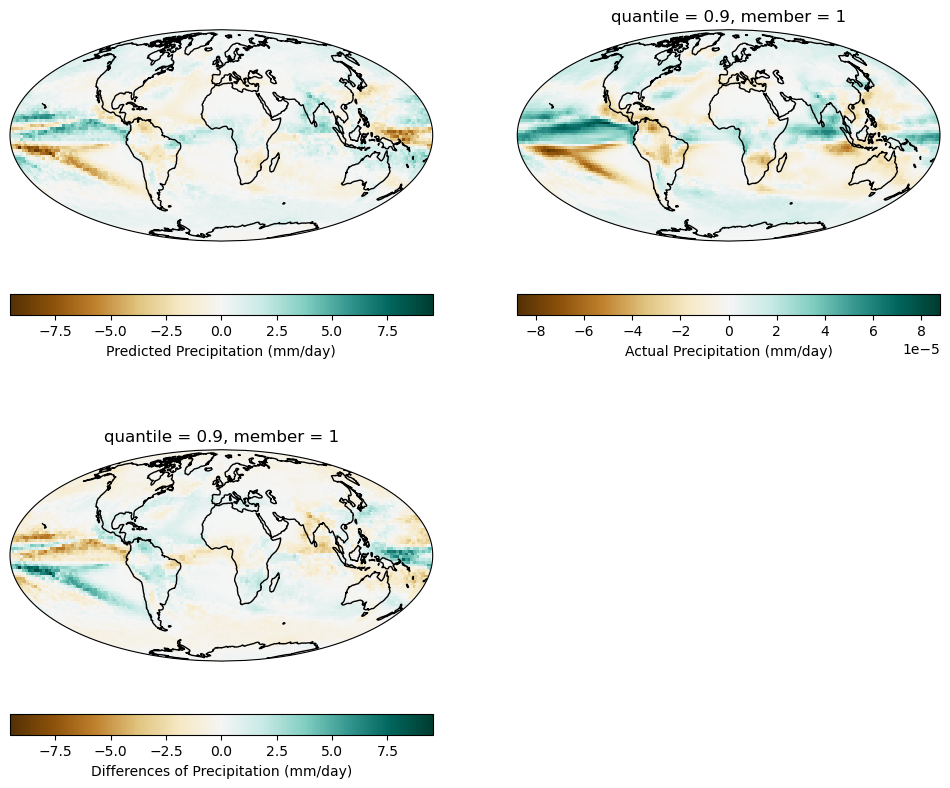

In [210]:
#getting plot for the predicted pr90
fig = plt.figure(figsize=(12, 10))
plt.subplot(221, projection=ccrs.Mollweide())
xr_output_pr90['pr90'].sel(time=slice(2080, 2100)).mean(['time']).plot(cmap="BrBG", transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Predicted Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting plot for the actual pr90

plt.subplot(222, projection=ccrs.Mollweide())
test_Y['pr90'].sel(time=slice(2080, 2100),member=1).mean(['time']).plot(cmap="BrBG", transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Actual Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting the abs difference between actual and predicted pr90
diff_pr = test_Y["pr90"].sel(time=slice(2080,2100),member=1).mean(['time']) - xr_output_pr90["pr90"].sel(time=slice(2080, 2100)).mean(['time'])

plt.subplot(223, projection=ccrs.Mollweide())
diff_pr.plot(cmap='BrBG', transform=ccrs.PlateCarree(),cbar_kwargs={"label":"Differences of Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

In [211]:
#create dataset for predicted value
xr_output=xr.Dataset(coords={'time': test_X.time.values, 'lat': test_X.latitude.values, 'lon': test_X.longitude.values})
xr_output["tas"]=(['time', 'lat', 'lon'],  pred_tas1)
xr_output["diurnal_temperature_range"]=(['time', 'lat', 'lon'],  pred_dtr1)
xr_output["pr"]=(['time', 'lat', 'lon'],  pred_pr1)
xr_output["pr90"]=(['time', 'lat', 'lon'],  pred_pr901)

In [212]:
xr_output.to_netcdf('xr_output_xgboost.nc')